# CSC311 Lab 8: Naive Bayes for Classifying Movie Reviews

In this lab, we will build a naive bayes model to classify positive vs
negative movie reviews.

By the end of this lab , you will be able to:

1. Use the "bag of word" representation of text.
2. Build naive bayes classifiers to solve classification problems.
3. Analyze MLE vs Bayesian parameter estimation methods.
4. Use a naive bayes classifier to make predictions.

Please work in groups of 1-2 during the lab.


## Submission

Submit a PDF document called `lab09.pdf` on Markus.
You may also, optionally, submit your lab09.ipynb file. Your PDF file will be graded, but
we will ask the TAs to check your ipynb file in case any solutions are cut off. Annotations will be
made in the PDF file.
Your PDF file should contain the following:

- Part 1. your creation of the `vocab` list and report of the size of the vocabulary (1 point)
- Part 1. your implementation of the `make_bow` function (1 point)
- Part 2. your implementation of the `naive_bayes_mle` function (2 points)
- Part 2. your implementation of the `naive_bayes_map` function (2 points)
- Part 3. your implementation of the `make_prediction` function (3 points)
- Part 3. your training/validation accuracy of a logistic regression model trained on this data (1 point)

You may produce a PDF document by exploring the Colab document, but be careful to check
that the required code and output is not cut off.
This method is preferred, since we would be able to more easily help point out issues.

Alternatively, you may create a PDF document that contain the parts that are graded.
However, the feedback we are able to provide may be more limited.

In [11]:
import matplotlib.pyplot as plt
import numpy as np

%matplotlib inline

## Acknowledgements

Data is a variation of the one from https://www.kaggle.com/datasets/lakshmi25npathi/imdb-dataset-of-50k-movie-reviews,
pre-processed so that only 1000 words are in the training/test set.


## Part 1 Data

Start by running these two lines of code to download the data on to Google Colab.

In [ ]:
# Download tutorial data files.
!wget https://www.cs.toronto.edu/~lczhang/311/lab09/trainvalid.csv
!wget https://www.cs.toronto.edu/~lczhang/311/lab09/test.csv

--2025-03-08 23:45:48--  https://www.cs.toronto.edu/~lczhang/311/lab09/trainvalid.csv
Resolving www.cs.toronto.edu (www.cs.toronto.edu)... 128.100.3.30
Connecting to www.cs.toronto.edu (www.cs.toronto.edu)|128.100.3.30|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 1464806 (1.4M) [text/csv]
Saving to: ‘trainvalid.csv’

trainvalid.csv      100%[===================>]   1.40M  2.41MB/s    in 0.6s    

2025-03-08 23:45:49 (2.41 MB/s) - ‘trainvalid.csv’ saved [1464806/1464806]

--2025-03-08 23:45:49--  https://www.cs.toronto.edu/~lczhang/311/lab09/test.csv
Resolving www.cs.toronto.edu (www.cs.toronto.edu)... 128.100.3.30
Connecting to www.cs.toronto.edu (www.cs.toronto.edu)|128.100.3.30|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 491538 (480K) [text/csv]
Saving to: ‘test.csv’

test.csv            100%[===================>] 480.02K  2.08MB/s    in 0.2s    

2025-03-08 23:45:50 (2.08 MB/s) - ‘test.csv’ saved [491538/491538]



As always, we start by understanding what our data looks like. Notice that the
test set has been set aside for us. Both the training and test set files follow
the same format, where each line in the csv file contains the review text and
the string label "positive" or "negative".

In [ ]:
import csv
trainfile = "trainvalid.csv"
testfile = "test.csv"

# Training/Validation set
data = csv.reader(open(trainfile))
for i, line in enumerate(data):
    print(line)
    if i > 10:
        break

['im not sure i havent seen every episode but i still enjoyed it its hard to say which episode was my favorite', 'positive']
['this film has everything ask yourself are you a fan of and ive seen a lot of movies', 'positive']
['its not going to be the japanese version the show is great but', 'positive']
['i would love to see either of them in another movie', 'positive']
['this movie is great if you enjoy watching b class movies that is', 'positive']
['if you can do that it really is good s s s s i doubt it too bad', 'positive']
['this movie has some things that are pretty amazing first it is supposed to be based on a true story the problem was that by then you would be able to hear it', 'positive']
['first of all i want to point on screen play', 'positive']
['this is the best movie i have ever seen any movie that can get children to learn history is great', 'positive']
['lets start with the good things this is not a movie for kids the action scenes are great here too ok over to the thin

In [ ]:
# Test set (separated so that we will all have the same test set)
data = csv.reader(open(testfile))
for i, line in enumerate(data):
    print(line)
    if i > 10:
        break

['what a great film a great cast as well i really enjoy this movie', 'positive']
['i cant say enough about this movie sometimes it feels as if youre watching a real documentary', 'positive']
['it was probably the most black comedy ive seen i really do recommend it to you', 'positive']
['old movies new movies im not sure why i cant get a copy its about time for this to happen it doesnt seem like this should be so difficult', 'positive']
['that film is absolutely fantastic if you watch it with your friends it can be a very nice day', 'positive']
['one did not need it anyway she knows this man is different', 'positive']
['he was something never before seen he was all we ever needed', 'positive']
['lets take the second point first but it is only that moment all three white actors did the role in black face i heard different things about this so the film is definitely worth watching', 'positive']
['i also think this is one of the greatest movies of the last years', 'positive']
['a great mov

**Task**: How many positive reviews are in `trainvalid.csv`?  Negative reviews? What about in `test.csv`?

In [ ]:
train_positive_count = 0
train_negative_count = 0
for i, line in enumerate(csv.reader(open(trainfile))):
  if line[1] == 'positive':
    train_positive_count += 1
  else:
    train_negative_count += 1
print(f'the number of positive reviews in training set is {train_positive_count}.')
print(f'the number of negative reviews in training set is {train_negative_count}.')

test_positive_count = 0
test_negative_count = 0
for i, line in enumerate(csv.reader(open(testfile))):
  if line[1] == 'positive':
    test_positive_count += 1
  else:
    test_negative_count += 1
print(f'the number of positive reviews in test set is {test_positive_count}.')
print(f'the number of negative reviews in test set is {test_negative_count}.')

the number of positive reviews in training set is 6000.
the number of negative reviews in training set is 6000.
the number of positive reviews in test set is 2000.
the number of negative reviews in test set is 2000.


**Graded Task**: How many unique words are in the entire training/validation set?
This will be the size of our **vocabulary** when we convert to a bag-of-word representation.
To compute this value, produce a list `vocab` that contains a list of unique words
in `trainvalid.csv`.

Splitting sentences into words is typically not a trivial operation. For this lab, punctuations
and other special symbols have already been removed from the reviews. So, using python's
`string.split()` method is sufficient.

In [12]:
vocab_set = set()
for i, line in enumerate(csv.reader(open(trainfile))):
  vocab_set.update(line[0].split())

vocab = list(vocab_set)

print("Vocabulary Size: ", len(vocab)) # Please include the output of this statement in your submission

Vocabulary Size:  1000


**Graded Task**: Complete the function `make_bow`, which takes a list of `(review, label)` pairs
and a list of words in the vocabulary, and produces a data matrix consisting of bag-of-word features,
along with a vector of labels.

In [15]:
def make_bow(data, vocab):
    """
    Produce the bag-of-word representation of the data, along with a vector
    of labels. You *may* use loops to iterate over `data`. However, your code
    should not take more than O(len(data) * len(vocab)) to run.

    Parameters:
        `data`: a list of `(review, label)` pairs, like those produced from
                `list(csv.reader(open("trainvalid.csv")))`
        `vocab`: a list consisting of all unique words in the vocabulary

    Returns:
        `X`: A data matrix of bag-of-word features. This data matrix should be
             a numpy array with shape [len(data), len(vocab)].
             Moreover, `X[i,j] == 1` if the review in `data[i]` contains the
             word `vocab[j]`, and `X[i,j] == 0` otherwise.
        `t`: A numpy array of shape [len(data)], with `t[i] == 1` if
             `data[i]` is a positive review, and `t[i] == 0` otherwise.
    """
    X = np.zeros([len(data), len(vocab)])
    t = np.zeros([len(data)])

    vocab_index = {word: idx for idx, word in enumerate(vocab)}

    for i, (review, label) in enumerate(data):
      words = set(review.split())
      for word in words:
            if word in vocab_index:
                X[i, vocab_index[word]] = 1
      t[i] = 1 if label == "positive" else 0

    return X, t

# Separate data into training/validation, then call `make_bow` to produce
# the bag-of-word features
import random
random.seed(42)
data = list(csv.reader(open(trainfile)))
random.shuffle(data)
X_train, t_train = make_bow(data[:10000], vocab)
X_valid, t_valid = make_bow(data[10000:], vocab)

**Task**: It is a good idea to understand the distribution of relative word occurrences.
Produce the figure below, which shows how often each word occurs in the training set.

In [16]:
# produce the mapping of words to count
vocab_count_mapping = list(zip(vocab, np.sum(X_train, axis=0)))
vocab_count_mapping = sorted(vocab_count_mapping, key=lambda e: e[1], reverse=True)
for word, cnt in vocab_count_mapping:
    print(word, cnt)

the 6046.0
this 5162.0
i 4785.0
it 4767.0
a 4300.0
is 4172.0
to 3682.0
movie 3567.0
and 3366.0
of 3152.0
that 2588.0
was 2446.0
not 2244.0
but 2218.0
in 2097.0
you 2043.0
film 1951.0
have 1602.0
good 1558.0
one 1505.0
for 1472.0
what 1464.0
its 1460.0
all 1424.0
so 1302.0
just 1281.0
be 1190.0
really 1132.0
see 1068.0
like 1043.0
bad 1029.0
if 1014.0
dont 1005.0
there 1004.0
on 1001.0
are 998.0
about 983.0
they 932.0
well 928.0
time 907.0
very 890.0
as 889.0
at 888.0
with 863.0
great 847.0
seen 837.0
do 808.0
watch 780.0
no 778.0
would 693.0
can 693.0
acting 691.0
my 691.0
know 688.0
think 686.0
much 684.0
me 682.0
ever 681.0
more 673.0
story 665.0
out 652.0
movies 641.0
say 634.0
how 630.0
even 619.0
get 617.0
he 612.0
did 588.0
has 569.0
could 563.0
or 563.0
why 558.0
will 538.0
love 531.0
thats 529.0
better 520.0
some 516.0
too 514.0
made 511.0
were 505.0
first 504.0
funny 481.0
worst 472.0
had 470.0
then 469.0
didnt 454.0
we 449.0
make 447.0
never 433.0
people 431.0
best 429.0
when

If we plot these occurrences, we see that the more common words tend to occur much more frequently
compared to the less common words. This type of distribution occurs quite often in
typical data sets, where there are a **long tail** of words that occur infrequently.

Text(0, 0.5, 'Number of occurrences')

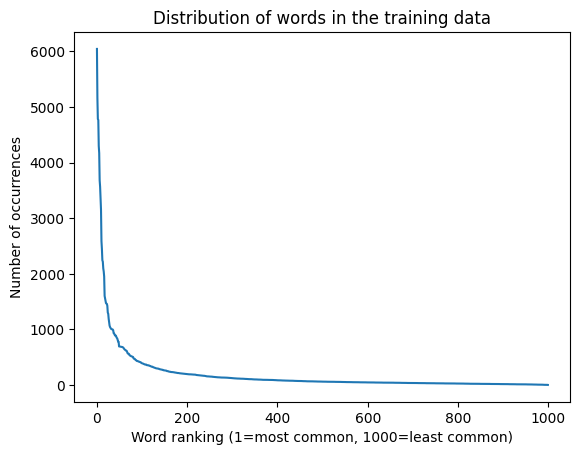

In [17]:
plt.plot([cnt for word, cnt in vocab_count_mapping])
plt.title("Distribution of words in the training data")
plt.xlabel("Word ranking (1=most common, 1000=least common)")
plt.ylabel("Number of occurrences")

## Part 2. Naive Bayes Model

In this section, we will build a naive bayes model to predict whether a movie review
is positive or negative. The naive bayes model is a generative model and a probabilistic classifier,
where we will make the **conditional independence assumption**:
$$p(c, x_1, \ldots, x_D) = p(c) p(x_1 | c) \cdots p(x_D | c)$$

Where $c$ is the label class  (positive or negative), and each $x_j \in {0, 1}$ represents whether
word $j$ appears in the review. We will fit parameters $\pi$ and $\theta_{jc}$, with:

- $p(c=1) = \pi$, representing the probability of positive class
- $p(x_j = 1 | c) = \theta_{jc}$, representing the probability of word $j$ appearing in a review with class $c$.

**Graded Task**: Implement the function `naive_bayes_mle` that computes the MLE estimation of
parameters. This function will produce the estimates of $\pi$ and the $\theta_{jc}$s that optimizes
the log likelihood of the training data:

$$\ell(\theta) = \sum_{i=1}^N \log p(c^{(i)}, {\bf x}^{(i)})$$

Like mentioned in class, this formula sounds scary, but the estimates of $\pi$ and $\theta_{jc}$ turns out
to require only basic counting operations and division.
As such, we can implement this function in an entirely vectorized way, **without using loops**.
Please do not use any loops in your solution.

In [18]:
def naive_bayes_mle(X, t):
    """
    Compute the parameters $pi$ and $theta_{jc}$ that maximizes the log-likelihood
    of the provided data (X, t).

    **Your solution should be vectorized, and contain no loops**

    Parameters:
        `X` - a matrix of bag-of-word features of shape [N, V],
              where N is the number of data points and V is the vocabulary size.
              X[i,j] should be either 0 or 1. Produced by the make_bow() function.
        `t` - a vector of class labels of shape [N], with t[i] being either 0 or 1.
              Produced by the make_bow() function.

    Returns:
        `pi` - a scalar; the MLE estimate of the parameter $\pi = p(c = 1)$
        `theta` - a matrix of shape [V, 2], where `theta[j, c]` corresponds to
                  the MLE estimate of the parameter $\theta_{jc} = p(x_j = 1 | c)$
    """
    N, vocab_size = X.shape[0], X.shape[1]
    pi = np.mean(t)
    theta = np.zeros([vocab_size, 2]) # TODO

    # these matrices may be useful (but what do they represent?)
    X_positive = X[t == 1]
    X_negative = X[t == 0]

    theta[:, 1] = np.sum(X_positive, axis=0) / X_positive.shape[0]
    theta[:, 0] = np.sum(X_negative, axis=0) / X_negative.shape[0]

    return pi, theta

pi_mle, theta_mle = naive_bayes_mle(X_train, t_train)

print(theta_mle.shape) # should be (1000, 2)

(1000, 2)


**Graded Task**: Implement the function `naive_bayes_map` that computes the MAP estimation of
parameters. This function will produce the estimates of $\pi$ and the $\theta_{jc}$s that maximizes
the posterior: $p(\theta | \mathcal{D})$, where $\theta = {\pi, \theta_{jc}}$ consists of all
of our parameters.

We will use the beta distribution with $a=2$ and $b=2$ for all of our parameters.

Once again, although these words might sound scary, the estimates of $\pi$ and $\theta_{jc}$ turns out
to require only basic counting operations and division---and not much more than the previous part!
Again, we can implement this function in an entirely vectorized way, **without using loops**.
Please do not use any loops in your solution.

In [20]:
def naive_bayes_map(X, t):
    """
    Compute the parameters $pi$ and $theta_{jc}$ that maximizes the posterior
    of the provided data (X, t). We will use the beta distribution with
    $a=2$ and $b=2$ for all of our parameters.

    **Your solution should be vectorized, and contain no loops**

    Parameters:
        `X` - a matrix of bag-of-word features of shape [N, V],
              where N is the number of data points and V is the vocabulary size.
              X[i,j] should be either 0 or 1. Produced by the make_bow() function.
        `t` - a vector of class labels of shape [N], with t[i] being either 0 or 1.
              Produced by the make_bow() function.

    Returns:
        `pi` - a scalar; the MAP estimate of the parameter $\pi = p(c = 1)$
        `theta` - a matrix of shape [V, 2], where `theta[j, c]` corresponds to
                  the MAP estimate of the parameter $\theta_{jc} = p(x_j = 1 | c)$

    """
    N = X.shape[0]
    vocab_size = X.shape[1]

    N_pos = np.sum(t)
    pi = (N_pos + 1) / (N + 2)

    X_positive = X[t == 1]
    X_negative = X[t == 0]

    theta = np.zeros((vocab_size, 2))

    theta[:, 1] = (np.sum(X_positive, axis=0) + 1) / (X_positive.shape[0] + 2)
    theta[:, 0] = (np.sum(X_negative, axis=0) + 1) / (X_negative.shape[0] + 2)

    return pi, theta


pi_map, theta_map = naive_bayes_map(X_train, t_train)

print(theta_map.shape) # should be (1000, 2)

(1000, 2)


## Part 3. Making predictions

**Graded Task**: Complete the function `make_prediction` which uses our estimated parameters $\pi$ and $\theta_{jc}$ to make predictions on our dataset.

Note that computing products of many small numbers leads to underflow. Use the fact that:

$$a_1 \cdot a_2 \cdots a_n = e^{log(a_1) + log(a_2) + \cdots + log(a_n)} $$

to avoid computing a product of small numbers.

In [21]:
def make_prediction(X, pi, theta):
    log_pi_0 = np.log(1 - pi)
    log_pi_1 = np.log(pi)

    log_theta_1 = np.log(theta[:, 1])
    log_theta_0 = np.log(theta[:, 0])

    log_1_minus_theta_1 = np.log(1 - theta[:, 1])
    log_1_minus_theta_0 = np.log(1 - theta[:, 0])

    log_prob_1 = log_pi_1 + X @ log_theta_1 + (1 - X) @ log_1_minus_theta_1
    log_prob_0 = log_pi_0 + X @ log_theta_0 + (1 - X) @ log_1_minus_theta_0

    y = (log_prob_1 > log_prob_0).astype(int)

    return y

def accuracy(y, t):
    return np.mean(y == t)


y_map_train = make_prediction(X_train, pi_map, theta_map)
y_map_valid = make_prediction(X_valid, pi_map, theta_map)

print("MAP Train Acc:", accuracy(y_map_train, t_train))
print("MAP Valid Acc:", accuracy(y_map_valid, t_valid))

MAP Train Acc: 0.7878
MAP Valid Acc: 0.785


At this point, you might wonder if the accuracy is "about right", and you might
ask your instructors/TAs about what the expected accuracy might be.
But what can we do to verify our results in real applications? One strategy
is to compare your model output with other known models.

**Graded Task**: Use sklearn to build a logistic regression model.
Report the training and validation accuracy.
You should see that the Logistic Regression model performs a bit better
than the Naive Bayes model. The Logistic Regression model does not make
as many assumptions about the data distribution that the Naive Bayes does.
(Think: what are these assumptions?)

In [22]:
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score


lr_model = LogisticRegression(max_iter=1000)
lr_model.fit(X_train, t_train)

y_train_pred = lr_model.predict(X_train)
y_valid_pred = lr_model.predict(X_valid)

train_acc = accuracy_score(t_train, y_train_pred)
val_acc = accuracy_score(t_valid, y_valid_pred)

# Print results
print("LR Train Acc:", train_acc)
print("LR Valid Acc:", val_acc)

LR Train Acc: 0.8248
LR Valid Acc: 0.787


This task is also a reminder that the bag of word features we built
are just *features*, and can be used with *any* model!

**Task**: The below code produces a warning or an error. Why?

In [23]:
y_mle_train = make_prediction(X_train, pi_mle, theta_mle)
y_mle_valid = make_prediction(X_valid, pi_mle, theta_mle)
print("MLE Train Acc:", accuracy(y_mle_train, t_train))
print("MLE Valid Acc:", accuracy(y_mle_valid, t_valid))

<ipython-input-21-3aa77e072194>:5: RuntimeWarning: divide by zero encountered in log
  log_theta_1 = np.log(theta[:, 1])
<ipython-input-21-3aa77e072194>:6: RuntimeWarning: divide by zero encountered in log
  log_theta_0 = np.log(theta[:, 0])
<ipython-input-21-3aa77e072194>:11: RuntimeWarning: invalid value encountered in matmul
  log_prob_1 = log_pi_1 + X @ log_theta_1 + (1 - X) @ log_1_minus_theta_1
<ipython-input-21-3aa77e072194>:12: RuntimeWarning: invalid value encountered in matmul
  log_prob_0 = log_pi_0 + X @ log_theta_0 + (1 - X) @ log_1_minus_theta_0


MLE Train Acc: 0.5007
MLE Valid Acc: 0.4965


**Task**: The function `predict` is written for you, and provides another way to
interact with the Naive Bayes model. The function takes a review (as a string),
and relevant information about the naive bayes model, and produce an estimate
for that single string.

Call `predict` several times, with short reviews that you write, to get a sense
of how the model behaves.

In [ ]:
def predict(review, vocab, pi, theta):
    x = np.zeros([1, len(vocab)])
    words = review.split()
    for j, w in enumerate(vocab):
        if w in words:
            x[0, j] = 1
    return make_prediction(x, pi, theta)[0]

predict("movie was fun", vocab, pi_map, theta_map)

**Task**: Explain why the MLE model fails to make predictions (or produces a warning) for a review
with the word "william" in it.

In [ ]:
print(predict("william", vocab, pi_map, theta_map)) # why does this succeed
print(predict("william", vocab, pi_mle, theta_mle)) # ...and this produce an error?

# Your explanation goes here

**Task**: Report the test accuracy on the naive bayes model with parameter estimation via MAP.

In [ ]:
# TODO

## Part 4. Analyzing the MAP Parameters

**Task**: Write code to print the following:

- the 10 words whose *presence* most strongly predicts that the review is positive
- the 10 words whose *absense* most strongly predicts that the review is positive
- the 10 words whose *presence* most strongly predicts that the review is negative
- the 10 words whose *absense* most strongly predicts that the review is negative

Note that these require more than just sorting the $\theta_{jc}$s! (Why?)

```
```